# Evaluation of the models

We will evaluate our probabilistic forecasts using the ROC diagram (Metz 1978), the attributes diagram (Hsu and Murphy 1986), and the performance diagram (Roebber 2009).

For this analysis, we will only present results for radar observations considered weak (ZH < 10 dBZ).

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from RadarQC.ml_lib.plotting.attributes_diagram import AttributesDiagram
from RadarQC.ml_lib.plotting.roc_curve import ROC
from RadarQC.ml_lib.plotting.performance_diagram import PerformanceDiagram

In [9]:
def generate_bootstrap_indices(data0, number_of_samples=1000, nboots=1):
    '''Generate bootstrap resampled indices.
    Inputs:
        data0 (np.array) : indices to resample.
        number_of_samples (int) : how many samples to generate per iteration
        nboots (int) : number of bootstrap iterations. '''

    bootstrap_indices = [np.random.choice(data0.index, size=number_of_samples, replace=True)
                    for _ in range(nboots)]
    
    return bootstrap_indices

In [8]:
#--------------------- D E C L A R A T I O N S---------------------------------#
# figure output information
outdir  = os.getcwd()

# set the target and prediction variable
target = 'valid_precip'
prediction_label = f"prob_{target}"

# set the number of nbootstrap resamples and samples to collect
nboots = 100
n_samples = 50000

# number of bins for contingency tables and plotting
nbins=10

# variables related to thresholding for final evaluation
data_thresholding = True
threshold = 10.0
variable_to_threshold = 'mean_zh'

# declarations for plotting
colors = ["xkcd:fire engine red", "xkcd:water blue", "xkcd:medium green"]
labels = ['LR', 'RF', 'CNN']
line_width = 2

# directory where the predictions are stored
parent_data_directory = '../data/'

In [10]:
# below are the model files created from the pipeline scripts
model_files = ['LR_predictions.csv', 'RF_predictions.csv', 'CNN_predictions.csv']
nmodels = len(model_files)

In [11]:
# clarify nboots for proper indexing
nboots = 1 if nboots is None else nboots
bootstrap_indices = []

# ROC Diagram

Bootstrapping LR_predictions.csv 100 times...
(205262, 46)
{'AUC': (0.886, 0.891, 0.894), 'best_threshold': 0.38}
Bootstrapping RF_predictions.csv 100 times...
(205262, 46)
{'AUC': (0.898, 0.902, 0.905), 'best_threshold': 0.305}
Bootstrapping CNN_predictions.csv 100 times...
(205262, 42)
{'AUC': (0.927, 0.931, 0.934), 'best_threshold': 0.299}


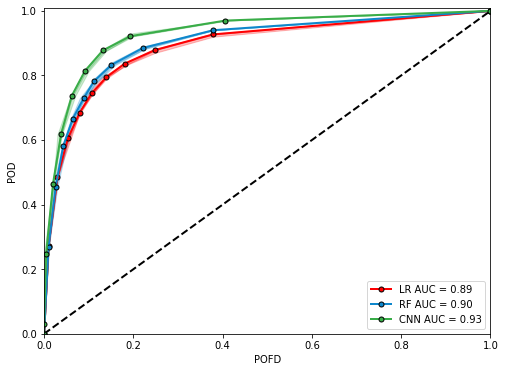

In [12]:
# initialize ROC object
roc_obj = ROC()

# loop over each model and create evaluation figures/statistics
for i, ml_file in enumerate(model_files):

    print(f"Bootstrapping {ml_file} {nboots} times...")
    data = pd.read_csv(parent_data_directory+ml_file)
    data = data.dropna(axis=0, how='any')
    print(data.shape)

    # subset data if desired
    if (data_thresholding is True):
        filter = data[variable_to_threshold] < threshold
        data = data[filter]
        data.reset_index(drop=True, inplace=True)

    infin = np.where(~np.isfinite(data[prediction_label].to_numpy()))
    if (len(infin[0]) > 0): data.loc[infin[0],prediction_label] = 0.0

    # subset data if desired
    if (data_thresholding is True):
        filter = data[variable_to_threshold] < threshold
        data = data[filter]
        data.reset_index(drop=True, inplace=True)

    # get boot strap indices
    if (nboots > 1):
        if (len(bootstrap_indices) == 0):
            bootstrap_indices = generate_bootstrap_indices(data, number_of_samples=n_samples, nboots=nboots)
    else:
        bootstrap_indices = None

    targets = data[target].to_numpy()
    predictions = data[prediction_label].to_numpy()

    # compute roc curve and plot
    roc_obj.make_curve(targets, predictions, nprob_bins=nbins, boostrap_indices_list=bootstrap_indices)
    fig_roc = roc_obj.plot_curve(color=colors[i], curve_label=labels[i])
    print(roc_obj.get_params())

# Performance Diagram

Bootstrapping LR_predictions.csv 100 times...
(205262, 46)
0.55 1.03 0.54
{'AUPD': (0.746, 0.753, 0.761), 'best_threshold': 0.55}
Bootstrapping RF_predictions.csv 100 times...
(205262, 46)
0.55 0.97 0.55
{'AUPD': (0.759, 0.768, 0.775), 'best_threshold': 0.55}
Bootstrapping CNN_predictions.csv 100 times...
(205262, 42)
0.5 0.96 0.6
{'AUPD': (0.816, 0.823, 0.831), 'best_threshold': 0.5}


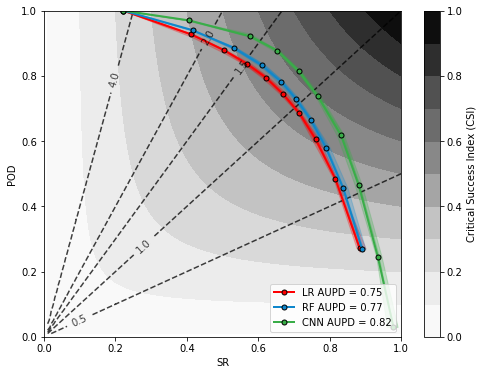

In [13]:
# Initialize PD object
pd_obj = PerformanceDiagram()

# loop over each model and create evaluation figures/statistics
for i, ml_file in enumerate(model_files):

    print(f"Bootstrapping {ml_file} {nboots} times...")
    data = pd.read_csv(parent_data_directory+ml_file)
    data = data.dropna(axis=0, how='any')
    print(data.shape)

    # subset data if desired
    if (data_thresholding is True):
        filter = data[variable_to_threshold] < threshold
        data = data[filter]
        data.reset_index(drop=True, inplace=True)

    infin = np.where(~np.isfinite(data[prediction_label].to_numpy()))
    if (len(infin[0]) > 0): data.loc[infin[0],prediction_label] = 0.0

    # subset data if desired
    if (data_thresholding is True):
        filter = data[variable_to_threshold] < threshold
        data = data[filter]
        data.reset_index(drop=True, inplace=True)

    # get boot strap indices
    if (nboots > 1):
        if (len(bootstrap_indices) == 0):
            bootstrap_indices = generate_bootstrap_indices(data, number_of_samples=n_samples, nboots=nboots)
    else:
        bootstrap_indices = None

    targets = data[target].to_numpy()
    predictions = data[prediction_label].to_numpy()

    # compute performance diagram and plot
    pd_obj.make_curve(targets, predictions, nprob_bins=nbins, boostrap_indices_list=bootstrap_indices)
    fig_pd = pd_obj.plot_curve(color=colors[i], curve_label=labels[i])
    print(pd_obj.get_params())

# Attributes Diagram

Bootstrapping LR_predictions.csv 100 times...
(205262, 46)
{'BSS': 0.4138, 'REL': 0.0062, 'RES': 0.0774, 'UNC': 0.173}
Bootstrapping RF_predictions.csv 100 times...
(205262, 46)
{'BSS': 0.4568, 'REL': 0.0029, 'RES': 0.0815, 'UNC': 0.173}
Bootstrapping CNN_predictions.csv 100 times...
(205262, 42)
{'BSS': 0.532, 'REL': 0.0033, 'RES': 0.0949, 'UNC': 0.173}


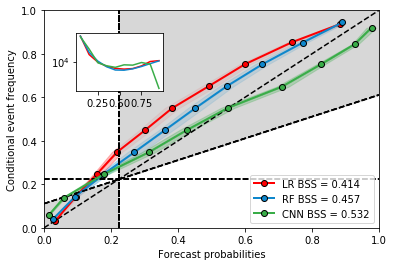

In [14]:
# initialize attributes diagram object
ad_obj = AttributesDiagram()

# loop over each model and create evaluation figures/statistics
for i, ml_file in enumerate(model_files):

    print(f"Bootstrapping {ml_file} {nboots} times...")
    data = pd.read_csv(parent_data_directory+ml_file)
    data = data.dropna(axis=0, how='any')
    print(data.shape)

    # subset data if desired
    if (data_thresholding is True):
        filter = data[variable_to_threshold] < threshold
        data = data[filter]
        data.reset_index(drop=True, inplace=True)

    infin = np.where(~np.isfinite(data[prediction_label].to_numpy()))
    if (len(infin[0]) > 0): data.loc[infin[0],prediction_label] = 0.0

    # subset data if desired
    if (data_thresholding is True):
        filter = data[variable_to_threshold] < threshold
        data = data[filter]
        data.reset_index(drop=True, inplace=True)

    # get boot strap indices
    if (nboots > 1):
        if (len(bootstrap_indices) == 0):
            bootstrap_indices = generate_bootstrap_indices(data, number_of_samples=n_samples, nboots=nboots)
    else:
        bootstrap_indices = None

    targets = data[target].to_numpy()
    predictions = data[prediction_label].to_numpy()

    # compute attributes diagram and plot
    ad_obj.make_curve(targets, predictions, nprob_bins=nbins, boostrap_indices_list=bootstrap_indices)
    fig_ad = ad_obj.plot_curve(color=colors[i], curve_label=labels[i])
    print(ad_obj.get_params())
    

Overall, each of the three ML models performed well and are considered skillfull. The CNN may be considered the most skillful model here. AUCs are ~0.9 for each model, with the CNN having the highest AUC of 0.93. The performance diagram curves are general in the upper right portion of the graph (high CSI) which is desirable. The probabilities themselves are also modestly reliable. The RF and LR models have a tendency to underforecast compared to the observations.

Eventually, these probabilities would need to be turned into a deterministic value or meteorological or not. This would be done to minimize forecast bias such that there is very little over/under forecasting.